In [63]:
import pandas as pd
import pymysql
db_info = pymysql.connect(user='root', passwd='root',host='localhost',port=3306, db='test')
cursor = db_info.cursor()

In [64]:
def user_log_data():
    cursor.execute("SELECT * FROM user_log")

    result = []
    for c in cursor:
        res = dict()
        res['reg_time'] = c[1]
        res['user_id'] = c[2]
        res['book_id'] = c[3]
        result.append(res)
    return pd.DataFrame(result).sort_values(by='reg_time',ascending=False).drop_duplicates(['user_id','book_id'],keep='first').reset_index(drop=True)


def book_data():
    cursor.execute("SELECT * FROM book")

    result = []
    for c in cursor:
        res = dict()
        res['book_id'] = c[0]
        res['category_id'] = c[4]
        result.append(res)

    return pd.DataFrame(result)


def user_category_data():
    cursor.execute("SELECT * FROM user_category")

    result = []
    for c in cursor:
        res = dict()
        res['user_id'] = c[1]
        res['user_category_id'] = c[2]
        result.append(res)

    return pd.DataFrame(result)


def review_data():
    cursor.execute("SELECT * FROM review")

    result = []
    for c in cursor:
        res = dict()
        res['book_id'] = c[5]
        res['user_id'] = c[4]
        res['rank'] = c[1]
        res['reg_time'] = c[3]
        res['content'] = c[2]
        result.append(res)

    return pd.DataFrame(result).sort_values(by='reg_time',ascending=False).drop_duplicates(['user_id','book_id'],keep='first').reset_index(drop=True)

In [111]:
user_log = user_log_data()
user_category = user_category_data()
book = book_data()
review = review_data()

In [112]:
from sklearn.preprocessing import MultiLabelBinarizer

user_id =1 

user_category['user_category_id'] = user_category['user_category_id'].astype(str)
user_cate = user_category.groupby('user_id').agg(lambda x: ' '.join(set(x)))
user_cate['user_category_id'] = user_cate['user_category_id'].str.split(' ')


cate_list = book['category_id'].unique()
for cate in cate_list:
    user_cate['c_' + str(cate)] = 0
    
mlb = MultiLabelBinarizer()
user_cate[user_cate.columns[1:]] = mlb.fit_transform(user_cate['user_category_id'])
user_cate.drop('user_category_id',axis=1, inplace=True)

que = f'user_id=={user_id}'

if(len(user_log.query(que)) != 0):
    data1 = pd.merge(user_log[["book_id", "user_id"]],
                     review, how="left", on=["book_id", "user_id"])
    data1['content'].fillna('', inplace=True)
    data1['content'] = data1['content'].str.replace(
        pat=r'[^A-Za-z0-9가-힣 ]', repl=r'', regex=True).str.strip()
    data1['rank'].fillna(int(data1['rank'].mean()), inplace=True)
    data1 = pd.merge(data1, book, on="book_id")

    user_see_cate = data1.groupby(['user_id', 'category_id'])[
        'rank'].mean().unstack().fillna(0)
    user_cate = pd.concat([user_cate, user_see_cate], axis=1).fillna(0)

if(len(review.query(que)) != 0):
    # 리뷰 데이터 tf idf
    tfidf = TfidfVectorizer(stop_words='english', max_features=300)
    tfidf_matrix = tfidf.fit_transform(data1['content'])
    tfidf_data = pd.DataFrame(tfidf_matrix.toarray(),
                              index=data1['user_id']).reset_index()
    tfidf_g_data = tfidf_data.groupby('user_id').mean()
    user_cate = pd.concat([user_cate, tfidf_g_data], axis=1).fillna(0)

In [126]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3,random_state=0)
pca.fit(user_cate_tf)
pca_samples = pca.transform(user_cate_tf)
ps = pd.DataFrame(pca_samples, index=user_cate_tf.index)

In [115]:
pca.explained_variance_ratio_.sum()

0.5012617092672619

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use('ggplot')

In [127]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(ps)
    scores.append(silhouette_score(ps, kmeans.labels_))


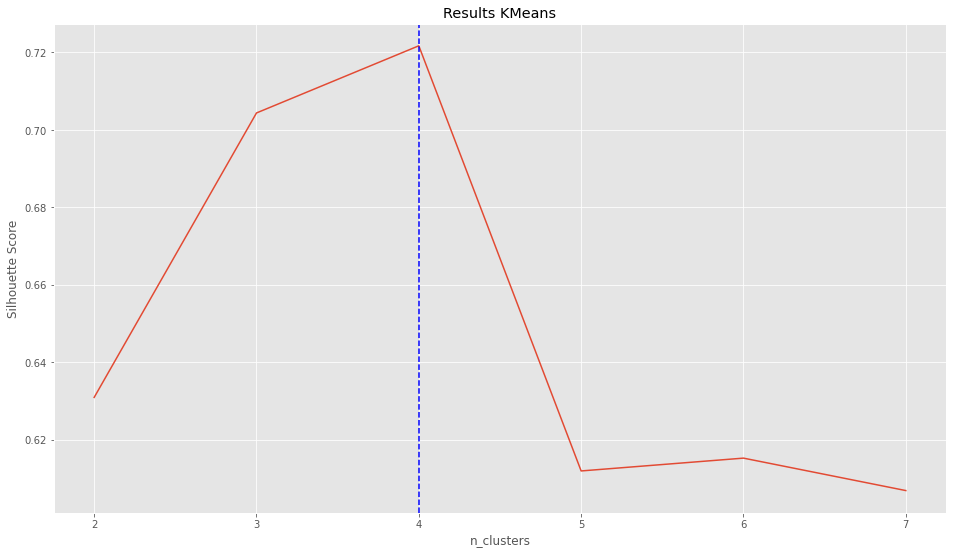

In [128]:
plt.plot(range(2,8), scores);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=4, color='blue', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

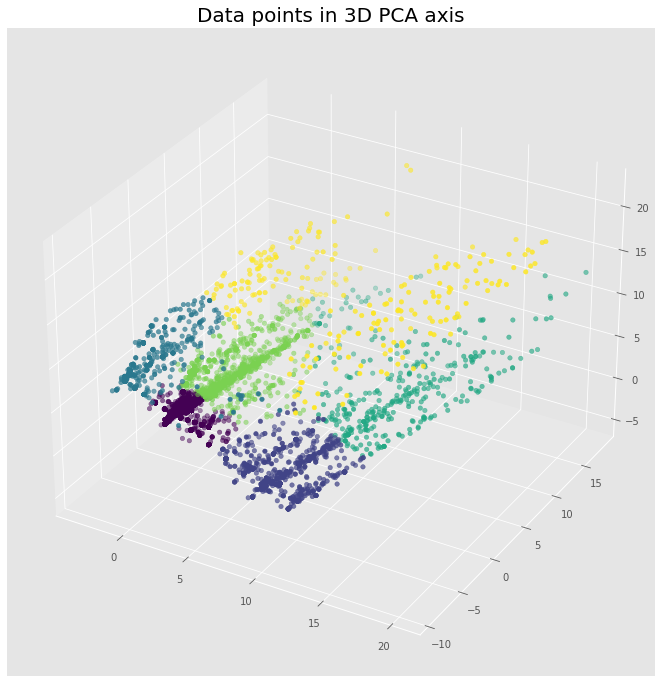

In [129]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(ps)

plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(ps[0], ps[2], ps[1], c=kmeans.labels_)

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

In [130]:
pred = kmeans.predict(ps.loc[1,:].to_frame().T)
user_cate_tf['cluster'] = kmeans.labels_
user_cate_tf_cluster = user_cate_tf[user_cate_tf['cluster']==pred[0]].drop('cluster',axis=1)

In [131]:
user_cate_tf['cluster'].value_counts()

0    13875
4     4596
1     2747
2     2000
3      367
5      253
Name: cluster, dtype: int64

In [84]:
user_log_my = user_log[user_log['user_id'].isin(user_cate_tf_cluster.index)]
user_cate_my = user_category.query("user_id==1")
my_book = pd.merge(user_log_my[["book_id","user_id"]], review, on=["book_id","user_id"])
my_book_rank = my_book.pivot_table(values='rank',index='user_id',columns='book_id').fillna(0)
my_book_rank = my_book.groupby(['user_id','book_id'])["rank"].mean().unstack().fillna(0)
not_books = book[~book['book_id'].isin(user_log_my["book_id"].unique())]
not_books = not_books[not_books['category_id'].isin(user_log_my["book_id"].unique())]
user_cate_my

,user_id,user_category_id
0,1,74
1,1,798
2,1,112011


In [38]:
my_book_rank[not_books.to_list()] = 0

KeyboardInterrupt: 

In [213]:
cursor.close()